### SENSITIVITY

In [73]:
'''
Our energy range will be 50-150 KeV
'''

def sens(energy_init, energy_final, t, attenuation_txt, rho_dect, thickness_dect, A_dect,theta,\
         shield_leakage_txt, thickness_shield, neutron_spallation_txt):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d
    import scienceplots
    import pandas as pd
    plt.style.use(['science','no-latex'])
    
    energy = np.array(np.loadtxt(attenuation_txt)[:,0]*1000) #KeV
    mu = np.array(np.loadtxt(attenuation_txt)[:,1]*rho_dect) #cm^-1
    #logE, logmu = np.log10(energy), np.log10(mu)
    
    '''
    We need to find the K-edge before we do an interpolation for our data (if it exists)
    '''

    for i in range(len(mu)-1):

        if mu[i+1]-mu[i]>=50: #The gap expected between values should be big
            
            k_edge = i


            '''
            Once we obtained it, we interpolate our data
            '''
            
            f1 = interp1d(energy[:k_edge+1], mu[:k_edge+1])
            f2 = interp1d(energy[k_edge:], mu[k_edge:])

            xnew1 = np.linspace(energy_init, energy[k_edge], 500)
            ynew1 = f1(xnew1)   
        
            xnew2 = np.linspace(energy[k_edge],energy_final,501)
            ynew2 = f2(xnew2) 
        
            xnew=np.concatenate((xnew1,xnew2))
            ynew=np.concatenate((ynew1,ynew2))

            
            break

        else:

            f = interp1d(energy, mu)

            xnew = np.linspace(energy_init, energy_final, 1001)
            ynew = f(xnew) 

    #EFFICIENCY

    efficiency = 1-np.exp(-rho_dect*thickness_dect*ynew)
    #efficiency2 = 1-np.exp(-rho*thickness*ynew2)

    #efficiency=efficiency1+efficiency2


    #BACKGROUND NOISE

    #Aperture leakage

    b_cxb = efficiency*87.4*xnew**(-2.3)*np.pi*theta**2 #photons/cm^2/s/KeV
   
    #Shield leakage

    E_sl = np.array(np.loadtxt(shield_leakage_txt)[:,0]) #KeV
    B_sl = np.array(np.loadtxt(shield_leakage_txt)[:,1]) 

    '''
    We should interpolate again just to evaluate the shield leakage in our energy array 
    '''

    f_sl = interp1d(E_sl, B_sl)

    bl_5cm = f_sl(xnew)

    '''
    The data is referred to a shield with 5 cm thickness,
    we should convert it for our purposes
    '''

    b_l=bl_5cm*np.exp(1-(thickness_shield/5)) #cm
    


    #Neutron and spallation induced

    '''
    We are choosing a high earth orbit (HEO), so the rigidity will be 2 GV
    '''

    Ens = np.array(np.loadtxt(neutron_spallation_txt)[:,0]) #KeV
    Bns = np.array(np.loadtxt(neutron_spallation_txt)[:,1])/1e3


    '''
    One more interpolation
    '''

    f_ns=interp1d(Ens,Bns)

    b_ns_fig=f_ns(xnew)

    '''
    We should correct the neutron-spallation background contribution because we are using another material.
    We are taking the rigidity correction factor as  F(Rc)=1.28 
    '''
    b_ns=1.28*((rho_dect*thickness_dect*A_dect)/(3.67*4400))*b_ns_fig #cgs units


    #Total background

    b_total=b_cxb+b_l+b_ns


    #Sensitivity

    sens=(3/efficiency)*np.sqrt(4*b_total/(A_dect*t*xnew))

    #plt.subplots(1,1,figsize=(5,5))
    plt.plot(xnew,sens,lw=1.5,ls='-.')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(fontsize=14)
    plt.gcf().get_axes()[0].yaxis.get_offset_text().set_size(14) 
    plt.xlabel('E [keV]',fontsize=16)
    plt.ylabel('photons $\\rm cm^{-2} s^{-1} keV^{-1}$',fontsize=16)

    return np.array([b_cxb[0], b_cxb[250], b_cxb[500], b_cxb[750], b_cxb[1000]]),\
                  np.array([b_l[0], b_l[250], b_l[500], b_l[750], b_l[1000]]),\
                           np.array([b_ns[0], b_ns[250], b_ns[500], b_ns[750], b_ns[1000]])

### SENSITIVITY CURVE

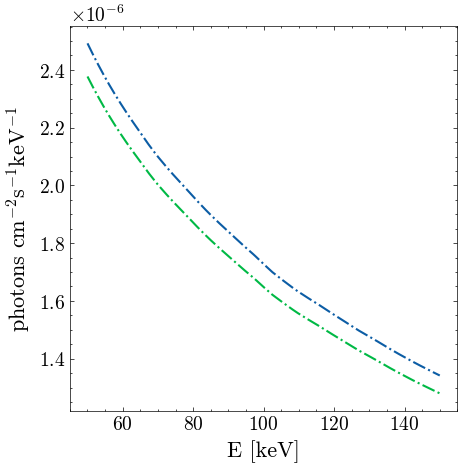

In [74]:
import matplotlib.pyplot as plt

'''
More than curve could be plotted at the same time
'''
plt.subplots(1,1,figsize=(5,5))
for n in (81.9e3,90e3):
  sens(50,150,n,'CdTe.txt',3.67,1.25,4e4,0.1,\
     'shield_leakage_background_CsI_Tl_5cm.dat',4,'neutron_spallation_background_NaI_Tl_2cm_4p7GV.dat') 
plt.show()

### BACKGROUND NOISE

In [75]:
a,b,c=sens(50,150,81.9e3,'CdTe.txt',3.67,1.25,4e4,0.1,\
     'shield_leakage_background_CsI_Tl_5cm.dat',5,'neutron_spallation_background_NaI_Tl_2cm_4p7GV.dat') 

plt.clf()

<Figure size 350x262.5 with 0 Axes>

#### Aperture leakage

In [76]:
import pandas as pd
import matplotlib.pyplot as plt



df_cxb = pd.DataFrame({
    "E [keV]": [50, 75, 100, 125, 150],
    "$\\rm \\boldsymbol{B_{CXB}}$": [f'{a[0]:.2E}',f'{a[1]:.2E}',f'{a[2]:.2E}',f'{a[3]:.2E}',f'{a[4]:.2E}']})


df_cxb.style.format(precision=2, thousands=",", decimal=".").set_properties(**{'text-align': 'center'})\
   .hide(axis="index").set_properties(**{'font-size': '20px'})\
   .set_table_styles([{'selector': 'th', 'props': [('font-size', '20px'), ('text-align', 'center')]}])





E [keV],$\rm \boldsymbol{B_{CXB}}$
50,3.40E-04
75,1.34E-04
100,6.90E-05
125,4.13E-05
150,2.71E-05


#### Shield leakage

In [77]:

df_l = pd.DataFrame({
    "E [keV]": [50, 75, 100, 125, 150],
    "$\\rm \\boldsymbol{B_{l}}$": [f'{b[0]:.2E}',f'{b[1]:.2E}',f'{b[2]:.2E}',f'{b[3]:.2E}',f'{b[4]:.2E}']})


df_l.style.format(precision=2, thousands=",", decimal=".").set_properties(**{'text-align': 'center'})\
   .hide(axis="index").set_properties(**{'font-size': '20px'})\
   .set_table_styles([{'selector': 'th', 'props': [('font-size', '20px'), ('text-align', 'center')]}])


E [keV],$\rm \boldsymbol{B_{l}}$
50,9.09E-04
75,8.85E-04
100,8.49E-04
125,8.00E-04
150,7.45E-04


#### Neutron and spallation induced

In [78]:
df_ns = pd.DataFrame({
    "E [keV]": [50, 75, 100, 125, 150],
    "$\\rm \\boldsymbol{B_{n+s}}$": [f'{c[0]:.2E}',f'{c[1]:.2E}',f'{c[2]:.2E}',f'{c[3]:.2E}',f'{c[4]:.2E}']})


df_ns.style.format(precision=2, thousands=",", decimal=".").set_properties(**{'text-align': 'center'})\
   .hide(axis="index").set_properties(**{'font-size': '20px'})\
     .set_table_styles([{'selector': 'th', 'props': [('font-size', '20px'), ('text-align', 'center')]}])

E [keV],$\rm \boldsymbol{B_{n+s}}$
50,2.68E-02
75,2.69E-02
100,2.61E-02
125,2.50E-02
150,2.36E-02
